In [ ]:
import tensorflow as tf
import keras as k
print(tf.__version__)
print(k.__version__)

1.13.1
2.0.8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install requests
!pip install keras==2.0.8
!pip install tensorflow==1.13.1
!pip install "scikit-learn==0.21.3."
!pip install spacy==2.2.4
#!python -m spacy download en_core_web_lg
!python -m spacy download en_vectors_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 8.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.0.8 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 86 kB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 367 kB 66.8 MB/s 
     |████████████████████████████████| 3.2 MB 56.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently tak

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 7.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.3 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.6 MB 6.2 MB/s 
     |██████████████████████████

In [ ]:
#load all libraries
import cv2, spacy, numpy as np

from PIL import Image
%matplotlib inline
import os, argparse

import keras.backend as K

from sklearn.externals import joblib
from keras.models import model_from_json,Model,Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D,Dense, Flatten, Dropout
from keras.optimizers import SGD
import requests 
from google.colab import files as FILE
import os

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# File paths for the model, all of these except the CNN Weights are 
# provided in the repo, See the models/CNN/README.md to download VGG weights

VQA_model_file_name      = '/content/drive/MyDrive/Zayn Nissan Works/Ashfaq/VQA working/VQA_MODEL.json'
VQA_weights_file_name   = '/content/drive/MyDrive/Zayn Nissan Works/Ashfaq/VQA working/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = '/content/drive/MyDrive/Zayn Nissan Works/Ashfaq/VQA working/FULL_labelencoder_trainval.pkl'
CNN_weights_file_name   = '/content/drive/MyDrive/Zayn Nissan Works/Ashfaq/VQA working/vgg16_weights (3).h5'

In [ ]:
def pop(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')
    else:
        model.layers.pop()
        if not model.layers:
            model.outputs = []
            model.inbound_nodes = []
            model.outbound_nodes = []
        else:
            model.layers[-1].outbound_nodes = []
            model.outputs = [model.layers[-1].output]
        model.built = False

    return model


In [ ]:
def load_model_legacy(model, weight_path):
    import h5py
    f = h5py.File(weight_path, mode='r')
    flattened_layers = model.layers

    nb_layers = f.attrs['nb_layers']

    for k in range(nb_layers):
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        if not weights: continue
        if len(weights[0].shape) >2: 
            weights[0] = np.swapaxes(weights[0],0,3)
            weights[0] = np.swapaxes(weights[0],0,2)
            weights[0] = np.swapaxes(weights[0],1,2)
        flattened_layers[k].set_weights(weights)

    f.close()

In [ ]:
def vgg_16(weight_path=None):
    
    K.set_image_dim_ordering('th')  #Note that the pre_train weight we download is based on thenoa,not tensorflow
    
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64,3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
#     model.summary()
    if weight_path:
        # model.load_weights(weights_path)
        load_model_legacy(model, weight_path)

    #Remove the last two layers to get the 4096D activations
    model = pop(model)
    model = pop(model)
        

    return model

In [ ]:
#load image model
image_model = vgg_16(CNN_weights_file_name)

#removing the last two layers of vgg to get the features
new_input = image_model.input
hidden_layer = image_model.layers[-3].output

#new model containing the first 14 layers of vgg16
image_model = Model(new_input, hidden_layer)

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
image_model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/usr/l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [ ]:
def get_image_features(image_file_name):
    image_features = np.zeros((1, 4096))
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    # print im.shape

    im = im.transpose((2,0,1))
    # print im.shape

    im = np.expand_dims(im, axis=0)
    print (im.shape)

    image_features = image_model.predict(im)
    # print image_features
    
    return image_features

In [ ]:
! git clone https://github.com/Kartikaggarwal98/Visual-question-answering.git

Cloning into 'Visual-question-answering'...
remote: Enumerating objects: 38, done.
remote: Total 38 (delta 0), reused 0 (delta 0), pack-reused 38
Unpacking objects: 100% (38/38), done.


In [ ]:
! git clone https://github.com/iamaaditya/VQA_Demo.git

Cloning into 'VQA_Demo'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 152 (delta 3), reused 0 (delta 0), pack-reused 141
Receiving objects: 100% (152/152), 97.61 MiB | 28.14 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
! git clone https://github.com/singhbhupender1/VQA-Project.git

Cloning into 'VQA-Project'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


## Word Embedding Part

In [ ]:
max_len=30
def get_question_features(question):
    
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    
    word_embeddings = spacy.load('en_vectors_web_lg')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, max_len, 300))
    for j in range(len(tokens)):
            question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

In [ ]:
import spacy.cli
spacy.cli.download("en_vectors_web_lg")
word_embeddings = spacy.load("en_vectors_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


In [ ]:
obama = word_embeddings(u"obama")
america = word_embeddings(u"president")
banana = word_embeddings(u"banana")
monkey = word_embeddings(u"monkey")
orange=word_embeddings(u"orange")

In [ ]:
banana.similarity(orange)

0.5629939782223348

In [ ]:
obama.similarity(banana)

0.17831369261081714

## VQA

In [ ]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
    
    ''' Given the VQA model and its weights, compiles and returns the model '''

    vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return vqa_model

In [ ]:
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)
model_vqa.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:1252: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return cls(**config)
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:1252: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(trainable=True, unroll=False, input_dtype="float32", activation="tanh", stateful=False, batch_input_shape=[None, 30,..., name="lstm_4", go_backwards=False, return_sequences=True, unit_forget_bias=True, input_shape=(None, 300..., units=512, kernel_initializer="glorot_uniform", recurrent_initializer="orthogonal", recurrent_activation="hard_sigmoid", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0.0, recurrent_dropout=0.0, implementation=0)`
  return cls(**config)
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:1252: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(name="lstm_5", g

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
__________

## PREDICTING PART

In [ ]:
image_file_name = '/content/Visual-question-answering/cricket.jpg'
question = u"What are they playing?"

In [ ]:
image_features = get_image_features(image_file_name)
print (image_features.shape)

(1, 3, 224, 224)
(1, 4096)


In [ ]:
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
y_output = model_vqa.predict([question_features, image_features])

# This task here is represented as a classification into a 1000 top answers
# this means some of the answers were not part of training and thus would 
# not show up in the result.
# These 1000 answers are stored in the sklearn Encoder class
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))
    #print (str(round(y_output[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(label))

35.39 % green!
19.14 % blue!
11.08 % black!
11.01 % red!
7.03 % purple!


## For Image from online

In [ ]:
def get_image_model(CNN_weights_file_name):
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    #from models.CNN.VGG import VGG_16
    image_model = vgg_16(CNN_weights_file_name)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [ ]:
def get_image_feature(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))
        
    from skimage import io
    # if you would rather not install skimage, then use cv2.VideoCapture which surprisingly can read from url
    # see this SO answer http://answers.opencv.org/question/16385/cv2imread-a-url/?answer=16389#post-id-16389
    im = cv2.resize(io.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # convert the image to RGBA

    
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = get_image_model(CNN_weights_file_name).predict(im)[0]
    return image_features

In [ ]:
image_file_name = "http://www.newarkhistory.com/indparksoccerkids.jpg"
# get the image features
image_features = get_image_feature(image_file_name)

In [ ]:
question = u"Are they playing Frisbee?"

# get the question features
question_features = get_question_features(question)

In [ ]:
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

78.72 % yes!
21.28 % no!
0.0 % girl!
0.0 % halloween!
0.0 % left!


In [ ]:
question = u"What are they playing?"

# get the question features
question_features = get_question_features(question)

In [ ]:
y_output = model_vqa.predict([question_features, image_features])
warnings.filterwarnings("ignore", category=DeprecationWarning)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

55.44 % frisbee!
18.91 % tennis!
16.95 % baseball!
8.31 % soccer!
0.07 % ball!


In [ ]:
image_file_name = '/content/VQA-Project/images/test/test6.jpg'
question = u"What does the sign say?"

In [ ]:
image_features = get_image_feature(image_file_name)
print (image_features.shape)

(1, 4096)


In [ ]:
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))
    #print (str(round(y_output[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(label))

28.61 % stop!
27.55 % parking!
9.57 % no parking!
5.14 % stop sign!
4.66 % one way!


### Example

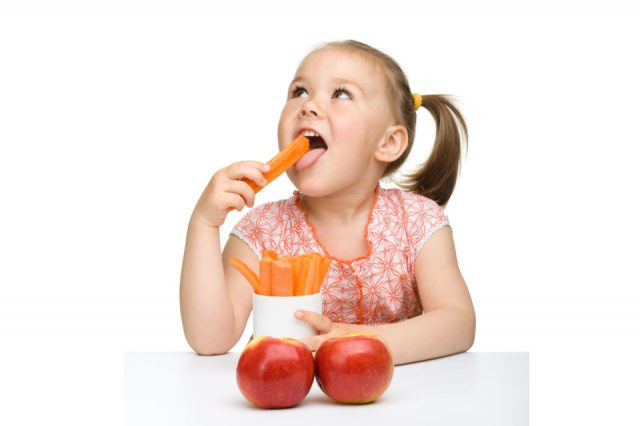

In [ ]:
image_file_name = '/content/VQA-Project/images/test/test3.jpg'
question = u"Is she eating apple?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [ ]:
image_features = get_image_feature(image_file_name)
print (image_features.shape)

(1, 4096)


In [ ]:
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])

# This task here is represented as a classification into a 10000 top answers
# this means some of the answers were not part of training and thus would 
# not show up in the result.
# These 1000 answers are stored in the sklearn Encoder class
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

63.06 % no!
36.94 % yes!
0.0 % toy!
0.0 % rainbow!
0.0 % parasailing!


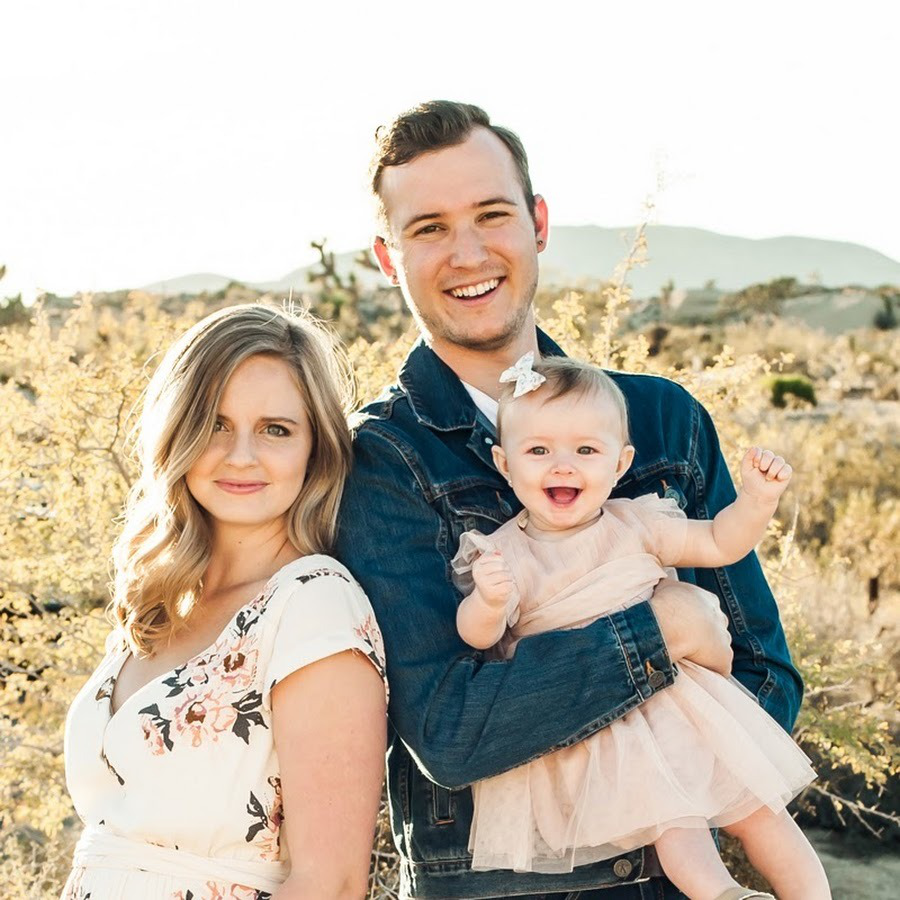

In [ ]:
image_file_name = '/content/VQA-Project/images/test/test2.jpg'
question = u"Is there baby?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [ ]:
image_features = get_image_feature(image_file_name)
print (image_features.shape)

In [ ]:
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

90.58 % yes!
9.41 % no!
0.0 % boy!
0.0 % christmas!
0.0 % girl!


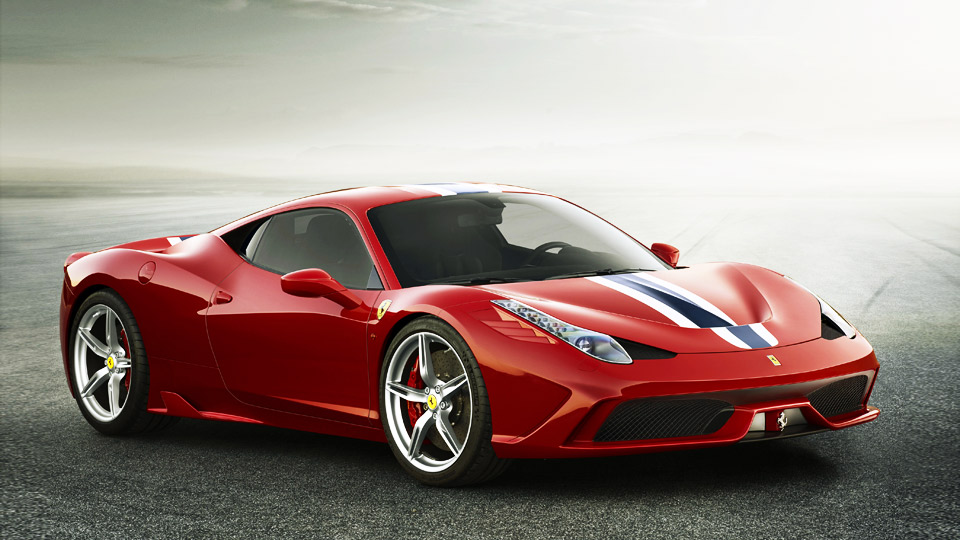

In [ ]:
image_file_name = '/content/VQA-Project/images/test/test4.jpg'
question = u"What colour is the car?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [ ]:
image_features = get_image_feature(image_file_name)
print (image_features.shape)

(1, 4096)


In [ ]:
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

79.92 % blue!
6.5 % silver!
3.59 % white!
3.07 % black!
1.38 % yellow!


In [ ]:
question = u"What  is the name of the car?"
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

26.07 % harley!
13.29 % yamaha!
12.03 % ford!
7.52 % harley davidson!
4.6 % police!


In [ ]:
question = u"Is it a car or a bike?"
question_features = get_question_features(question)
print (question_features.shape)

(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])

warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

76.77 % motorcycle!
7.36 % surfboard!
4.83 % car!
2.84 % skateboard!
1.8 % suitcase!


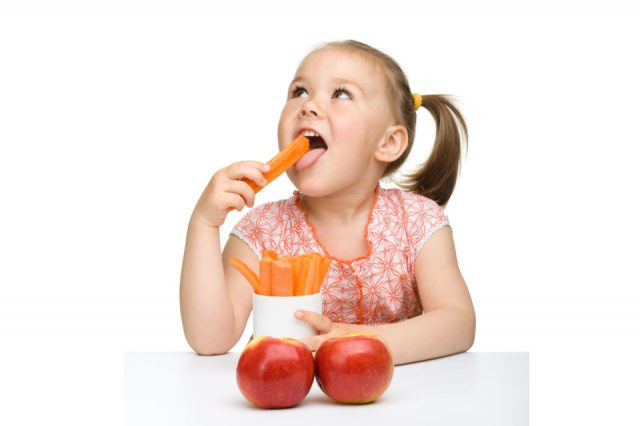

In [ ]:
image_file_name = '/content/VQA-Project/images/test/test3.jpg'
question = u"Is she eating apple?"

from PIL  import Image
im = Image.open(image_file_name)
im

In [ ]:
image_features = get_image_feature(image_file_name)
print (image_features.shape)

question_features = get_question_features(question)
print (question_features.shape)

(1, 4096)
(1, 30, 300)


In [ ]:
y_output = model_vqa.predict([question_features, image_features])
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

63.06 % no!
36.94 % yes!
0.0 % toy!
0.0 % rainbow!
0.0 % parasailing!


In [ ]:
!pip install requests
import requests 
from google.colab import files as FILE
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
img_data = requests.get('https://images.ctfassets.net/iyiurthvosft/1IIyTz3lomwbrZOVwsMZT3/9ed6cd282d162cabab11c560ec10265e/iStock-1164267861.jpg?fm=jpg&fl=progressive&q=50&w=1200').content
with open('image_name.jpg', 'wb') as handler:
    handler.write(img_data)

FILE.download('/content/image_name.jpg')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
###################################

image_file_name = 'https://images.hindustantimes.com/auto/auto-images/bikes/harleydavidson/harleydavidsoniron883/1630604053106_harleydavidsoniron883-1'
question = u"what is the colour of the bike?"

#from PIL  import Image
#im = Image.open(image_file_name)
#im

###################################

image_features = get_image_feature(image_file_name)
print (image_features.shape)

question_features = get_question_features(question)
print (question_features.shape)
print ("\n Answers \n")
#################################

y_output = model_vqa.predict([question_features, image_features])
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

(1, 4096)
(1, 30, 300)

 Answers 

48.26 % black!
23.65 % silver!
14.06 % blue!
9.1 % white!
2.44 % gray!


In [ ]:
import warnings
warnings.filterwarnings('ignore')
###################################

image_file_name = 'https://images.hindustantimes.com/auto/auto-images/bikes/harleydavidson/harleydavidsoniron883/1630604053106_harleydavidsoniron883-1'
question = u"what brand is the bike?"

#from PIL  import Image
#im = Image.open(image_file_name)
#im

###################################

image_features = get_image_feature(image_file_name)
print (image_features.shape)

question_features = get_question_features(question)
print (question_features.shape)
print ("\n Answers \n")
#################################

y_output = model_vqa.predict([question_features, image_features])
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

(1, 4096)
(1, 30, 300)

 Answers 

64.81 % harley!
12.67 % ford!
11.57 % harley davidson!
4.55 % yamaha!
2.75 % bmw!


In [ ]:
import warnings
warnings.filterwarnings('ignore')
###################################

image_file_name = 'https://thumbs.dreamstime.com/z/couple-love-playing-frisbee-park-concept-hea-couple-love-playing-frisbee-park-concept-120280972.jpg'
question = u"Are they playing frisbee?"

#from PIL  import Image
#im = Image.open(image_file_name)
#im

###################################

image_features = get_image_feature(image_file_name)
print (image_features.shape)

question_features = get_question_features(question)
print (question_features.shape)
print ("\n Answers \n")
#################################

y_output = model_vqa.predict([question_features, image_features])
warnings.filterwarnings("ignore", category=DeprecationWarning)
labelencoder = joblib.load(label_encoder_file_name)
for label in reversed(np.argsort(y_output)[0,-5:]):
    print("{} % {}!".format(round(y_output[0,label]*100,2), labelencoder.inverse_transform([label])[0]))

(1, 4096)
(1, 30, 300)

 Answers 

80.35 % yes!
19.64 % no!
0.0 % chicago!
0.0 % left!
0.0 % ocean!
